# Исследование показов рекламы

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу
экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за
просмотр получает монетки или др. ресурсы. Информация о каждом показе
отправляется в аналитику и содержит доход от показа, формат показанной
рекламы, рекламную сеть от которой был показ и др.

**Бизнес задача**

Провести исследование показов рекламы с целью понять на сколько
отличается eCPM в зависимости от географии (города) юзера, версии ОС и
других параметров.

In [ ]:
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 23.2 MB/s 
     |████████████████████████████████| 6.3 MB 30.9 MB/s 
     |████████████████████████████████| 16.7 MB 337 kB/s 


In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print('ошибка монтирования диска')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import math
import scipy
import plotly.graph_objects as go
from matplotlib.ticker import (
    PercentFormatter,
)  # чтоб оси на графике превращать в проценты
import seaborn as sns
import matplotlib.pyplot as plt
# from io import BytesIO
# import requests
# from matplotlib.collections import PathCollection
# from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
# import pickle
import json
from typing import Optional
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
try:
  df = pd.read_csv('https://drive.google.com/drive/folders/1bjWlzyXV8ALcoxZYrdNQH6_MOm3nS3Pl?us') # скачиваем датасет
except:
  print('ошибка связи с сетью')
try:
  df = pd.read_csv('/content/drive/MyDrive/us events ad_revenue filtered 03.02-07.02.csv') # если нет интернета
except:
  print('ошибка чтения с google диска')

df_raw = df.copy() # сохраняем сырые данные на случай дальнейших изменений датасета

ошибка связи с сетью


In [ ]:
# установка параметров системы
pd.options.display.max_columns = 100  # чтоб выводил все столбцы на экран
np.seterr(divide="ignore", invalid="ignore")
plt.rcParams["figure.figsize"] = (
    12,
    6,
)  # установить единый размер графиков по умолчанию

## Изучение и предобработка данных

Получим общую информацию о таблице:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

Итак, согласно документации к данным:

    Столбец profile_id – id юзера
    Столбец event_json содержит данные о событии показа рекламы:
    ad_type – формат рекламы (int, banner или rv)
    placement – когда/где был показ рекламы в игре
    view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
    revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
    ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
    network_name – рекламная сеть, от которой был показ


Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.


Выведем на экран первые пять строк таблицы:

In [ ]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Проверим, есть ли в данных производитель Apple:

In [ ]:
df["device_manufacturer"].str.lower().str.contains('apple', regex=False).sum()

0

Таким образом мы убедились, что реклама сосредоточена на пользователях Android.

В столбце `event_json` есть необходимые данные для извлечения. Взглянем на них:

In [ ]:
df_raw["event_json"].value_counts().head(5)

{"ad_type":"int","placement":"lose_offer_attempt_int","view_index":86,"session_view_index":6,"cur_ticks":637795152685579760,"session_length":1087.268,"revenue":0.00564017057418823,"ads_ltv":1.70973743083661,"ecpm_sma":7.90798664093018,"normalized_ecpm_sma":8.30670833587646,"value":0.00564017057418823,"currency":"USD","ad_country_code":"US","network_name":"AppLovin","ad_unit_id":"3ab7705b07ebb75f","ad_network_placement":"inter_regular","creativeId":"13600724"}                  2
{"ad_type":"banner","placement":"","view_index":1,"session_view_index":0,"cur_ticks":637795988491881280,"session_length":6984.719,"revenue":0.002020645,"ads_ltv":0.944953265026215,"ecpm_sma":2.02064490318298,"normalized_ecpm_sma":2.02064490318298,"value":0.002020645,"currency":"USD","ad_country_code":"US","network_name":"Google AdMob","ad_unit_id":"64c6b1114ea8c1cc","ad_network_placement":"ca-app-pub-7511632782617496/4884242584","creativeId":"CODYwZSq5_UCFREFigMdoygPKQ"}      2
{"ad_type":"banner","placement":""

Получим данные из столбца `event_json`:

In [ ]:
df['ad_type'] = df["event_json"].apply(lambda x: json.loads(x)['ad_type'])

In [ ]:
df['placement'] = df["event_json"].apply(lambda x: json.loads(x)['placement'])

In [ ]:
df['view_index'] = df["event_json"].apply(lambda x: json.loads(x)['view_index'])

In [ ]:
df['revenue'] = df["event_json"].apply(lambda x: json.loads(x)['revenue'])

In [ ]:
df['ads_ltv'] = df["event_json"].apply(lambda x: json.loads(x)['ads_ltv'])

In [ ]:
df['network_name'] = df["event_json"].apply(lambda x: json.loads(x)['network_name'])

Переведем эти данные в числовой тип:

In [ ]:
df['revenue'] = df['revenue'].astype(float)
df['ads_ltv'] = df['ads_ltv'].astype(float)
df['view_index'] = df['view_index'].astype(np.int32)

После того как мы извлекли необходимую информацию, удалим столбец `event_json`:

In [ ]:
del df['event_json']

Посмотрим, есть какие значения есть в столбце `event_name`:

In [ ]:
df_raw["event_name"].value_counts()

c_ad_revenue    860079
Name: event_name, dtype: int64

Поскольку этот столбец только с одним значением, от него можно избавиться:

In [ ]:
del df["event_name"]

Посмотрим, есть какие значения есть в столбце `network_name`:

In [ ]:
df['network_name'].value_counts()

Google AdMob         484728
APPLOVIN_EXCHANGE    338427
AppLovin              20831
Facebook              16093
Name: network_name, dtype: int64

Всего задействованы 4 сети размещения рекламы.

Посмотрим, есть какие значения есть в столбце `operator_name`:

In [ ]:
df_raw["operator_name"].value_counts()

Verizon              288720
AT&T                 148377
T-Mobile             141402
Verizon               43935
U.S. Cellular         29631
                      ...  
Consumer Cellular         1
Ting                      1
Pioneer Cellular          1
Telrite/Pure Talk         1
EE                        1
Name: operator_name, Length: 92, dtype: int64

Посмотрим, есть какие значения есть в столбце `country_iso_code`:

In [ ]:
df['country_iso_code'].value_counts()

US    860079
Name: country_iso_code, dtype: int64

Данные только по США. Поскольку этот столбец только с одним значением, от него можно избавиться:

In [ ]:
del df["country_iso_code"]

Посмотрим, есть какие значения есть в столбце `device_locale`:

In [ ]:
df['device_locale'].value_counts()

en_US         856257
en_GB           1543
en_IN            875
en_CA            718
en_NL            438
ko_KR            147
fr_FR             43
zh-Hant_TW        41
en_AU             17
Name: device_locale, dtype: int64

Удалим дублирующие дату столбцы `event_timestamp`и `event_receive_timestamp`:

In [ ]:
del df['event_timestamp']
del df['event_receive_timestamp']

Построим гистограммы для числовых данных таблиц:

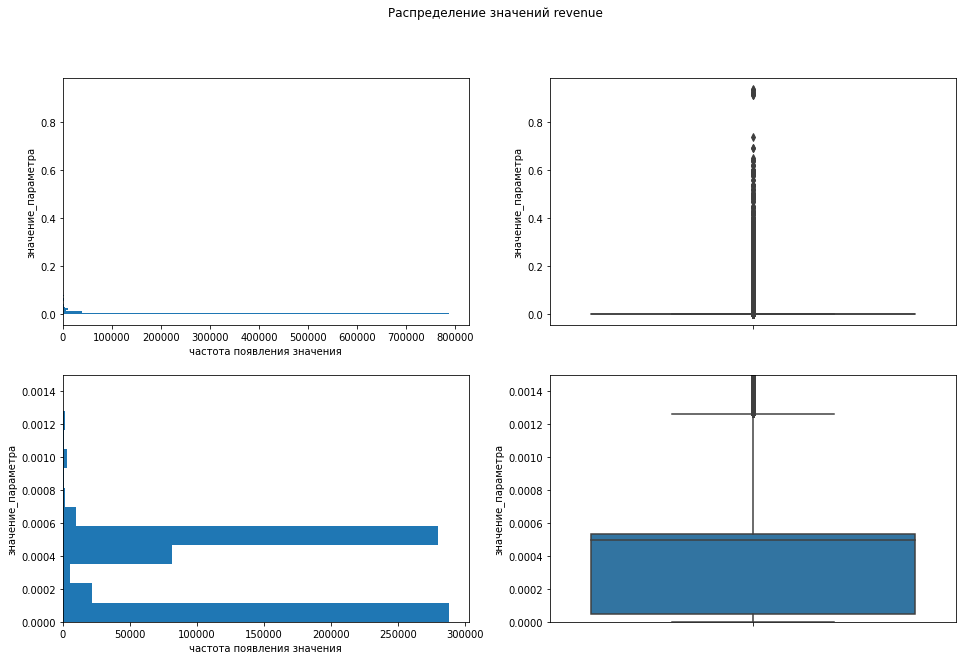

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение значений revenue")
y = df["revenue"]
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=8050)
ax[1, 0].set_ylim([0, 0.0015])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 0.0015])
ax[1, 1].set_xticklabels([])
plt.show()

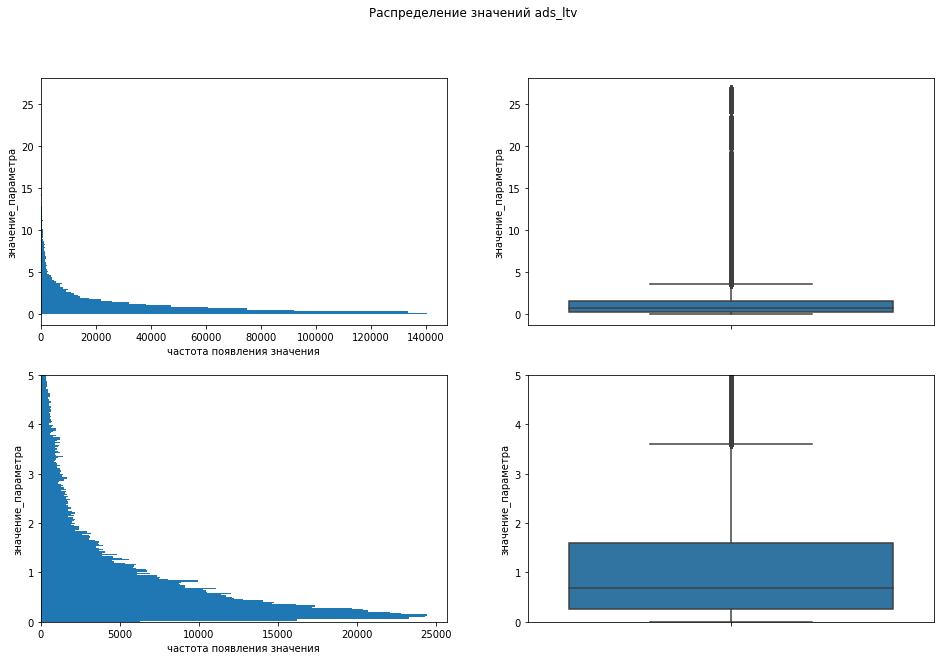

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение значений ads_ltv")
y = df["ads_ltv"]
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=1050)
ax[1, 0].set_ylim([0, 5])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 5])
ax[1, 1].set_xticklabels([])
plt.show()

Проверим более точно диапазон значений в `revenue`:

In [ ]:
df['revenue'].describe()

count    860079.000000
mean          0.002780
std           0.015129
min           0.000000
25%           0.000046
50%           0.000494
75%           0.000533
max           0.937196
Name: revenue, dtype: float64

Проблем с числовыми данными не обнаружено.

### Работа с пропусками

Заменим значения пропусков в столбцах на 'unknown':

In [ ]:
df["operator_name"] = df["operator_name"].fillna('unknown')
df["city"] = df["city"].fillna('unknown')
df["profile_id"] = df["profile_id"].fillna('unknown')
df["placement"] = df["placement"].fillna('unknown')

### Изменение типа данных

Чтобы можно было провести дальнейший исследовательский анализ, надо поменять тип данных в столбцах, которые содержат временные данные:

In [ ]:
df['event_datetime']  = pd.to_datetime(df['event_datetime'], format="%Y-%m-%d %H:%M:%S")  # меняем
df['event_receive_datetime']  = pd.to_datetime(df['event_receive_datetime'], format="%Y-%m-%d %H:%M:%S")  # меняем

И проверим распределение значений в столбцах:

In [ ]:
df['event_datetime'].describe(datetime_is_numeric=True)

count                           860079
mean     2022-02-05 22:02:44.454852352
min                2022-01-29 17:42:32
25%                2022-02-05 02:27:19
50%                2022-02-06 02:02:31
75%                2022-02-06 22:46:42
max                2022-02-07 23:59:59
Name: event_datetime, dtype: object

Итак, мы видим, что имеем дело с событиями, произошедшими с 29 января по 7 февраля.

In [ ]:
df['event_receive_datetime'].describe(datetime_is_numeric=True)

count                           860079
mean     2022-02-05 22:14:03.385469440
min                2022-02-03 00:00:02
25%                2022-02-05 02:35:47
50%                2022-02-06 02:08:50
75%                2022-02-06 22:54:35
max                2022-02-07 23:59:59
Name: event_receive_datetime, dtype: object

Добавим новый столбец `day`, который будет показывать в какой день произошло событие:

In [ ]:
df['day'] = pd.DatetimeIndex(df['event_datetime']).day 

In [ ]:
df["day"] = df["event_datetime"].to_numpy().astype('datetime64[D]')

In [ ]:
df['day'].value_counts()

2022-02-06    258192
2022-02-05    215383
2022-02-07    198959
2022-02-04    123495
2022-02-03     63454
2022-02-02       378
2022-02-01       143
2022-01-31        43
2022-01-30        26
2022-01-29         6
Name: day, dtype: int64

***Вывод***

У нас в распоряжении одна таблица с набором данных содержащих информацию о более чем 860000 показов реклам.

В процессе предобработки изменили тип данных в нескольких столбцах. Для удобства работы удалили лишние данные, заполнили пропуски.

## Исследовательский анализ данных

#### Составление первого впечатления

Для начала проверим как менялись просмотры рекламы за все время:

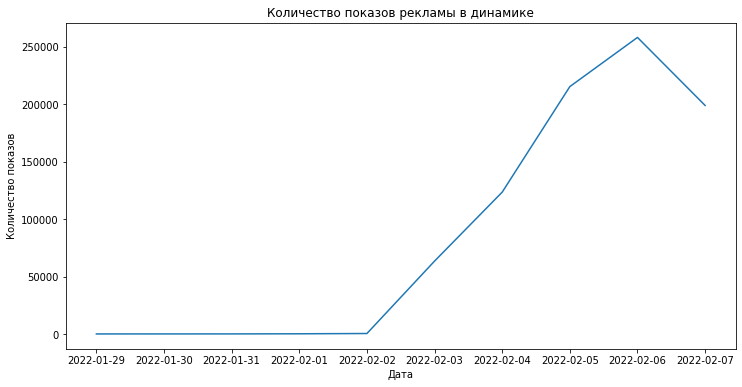

In [ ]:
t = df.groupby("day").agg({"revenue": "count" })
sns.lineplot(x="day", y="revenue", data=t)
plt.xlabel("Дата")
plt.ylabel("Количество показов")
plt.title('Количество показов рекламы в динамике')
plt.show()

Заметен резкий рост показов рекламы начиная с 3 февраля.

Посмотрим, как изменилась рекламная аудитория за это время:

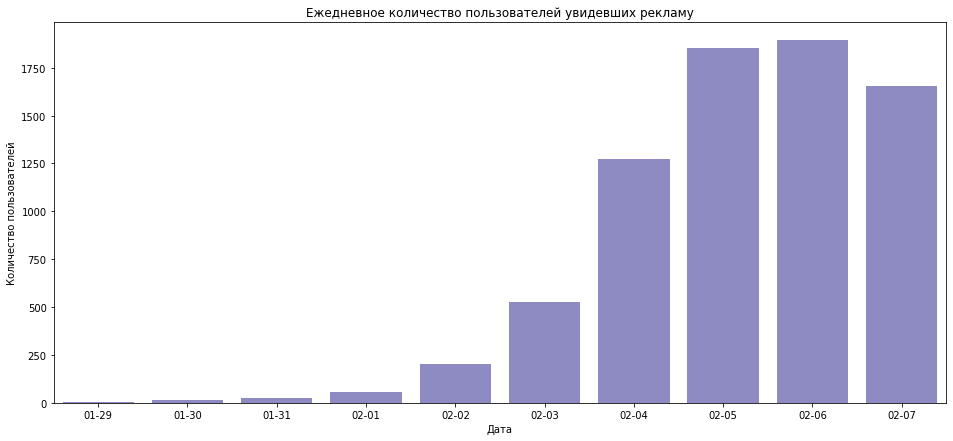

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
t = df.groupby(["day"]).agg({"profile_id": lambda x: x.value_counts().count()})
t = t.reset_index()
ax.set_ylabel("Количество лет существования платформы по имеющимся данным")
sns.barplot(
    x="day",
    y="profile_id",
    data=t, color="#8681cd"
)

x_dates = t['day'].dt.strftime('%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates)
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.title('Ежедневное количество пользователей увидевших рекламу')
plt.show()

Рекламная аудитория выросла.

Посмотрим, увеличилось ли количество показов рекламы на человека:

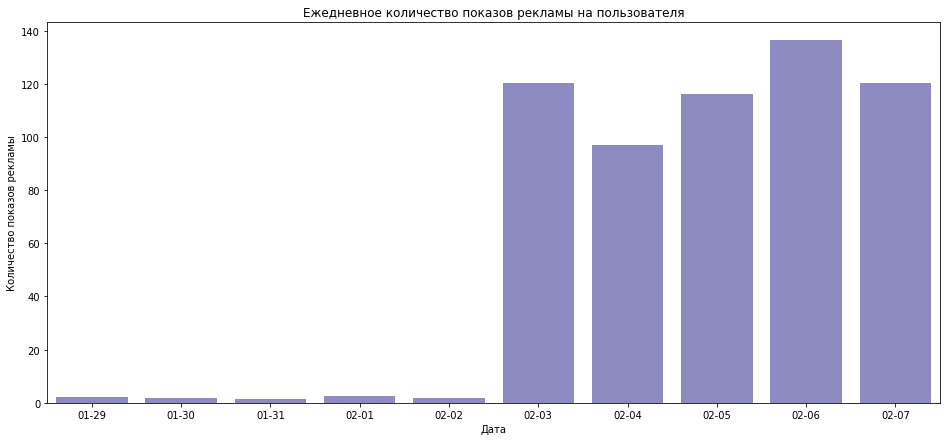

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
t = df.groupby(["profile_id","day"]).agg({"revenue": "count"})
t = t.reset_index()
t = t.groupby(["day"]).agg({"revenue": "mean"})
t = t.reset_index()

sns.barplot(
    x="day",
    y="revenue",
    data=t, color="#8681cd"
)
ax.set_ylabel("Количество лет существования платформы по имеющимся данным")
x_dates = t['day'].dt.strftime('%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates)
plt.xlabel("Дата")
plt.ylabel("Количество показов рекламы")
plt.title('Ежедневное количество показов рекламы на пользователя')
plt.show()

Просмотры на человека резко подскочили 3 февраля.

Проверим, в каких сетях продвижения и по каким форматам рекламы произошел рост показов на человека: <a id='app'></a>  

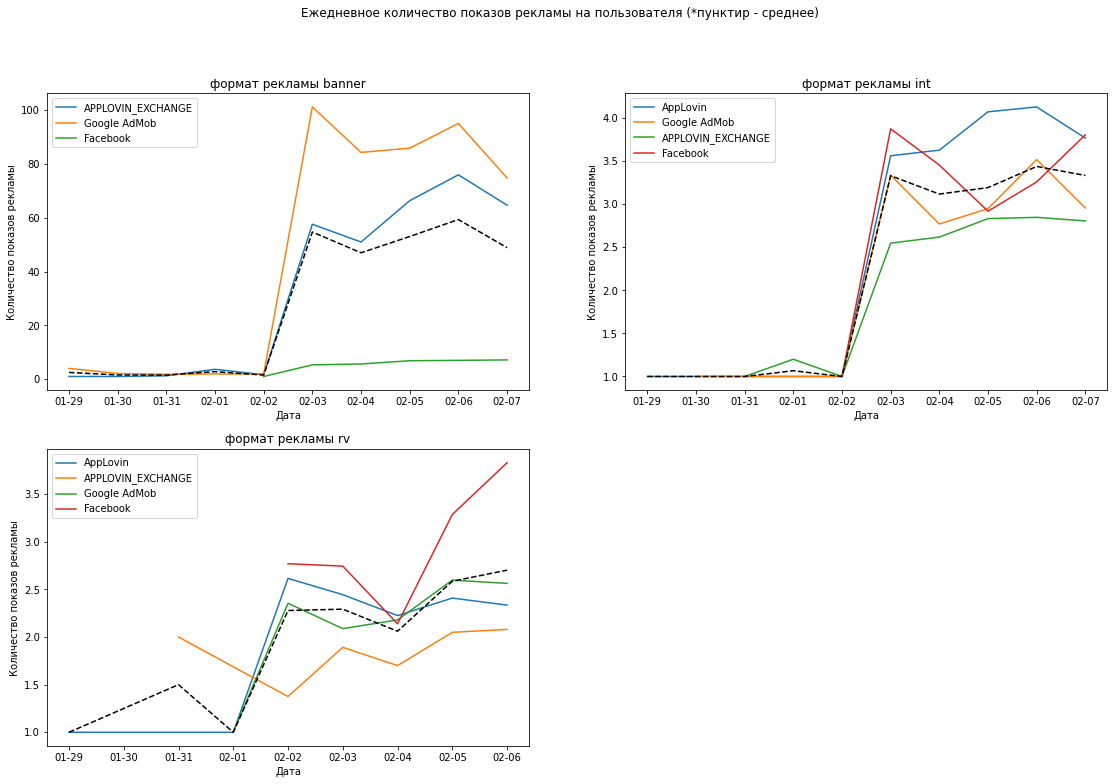

In [ ]:
t = df.groupby(["profile_id","day", "network_name","ad_type"]).agg({"revenue": "count"})
t = t.reset_index()
t = t.groupby(["day","network_name","ad_type"]).agg({"revenue": "mean"})
t = t.reset_index()

lst = df['ad_type'].value_counts().index.to_list()
n= len(lst)

fig = plt.figure( figsize=(19,12))
fig.suptitle("Ежедневное количество показов рекламы на пользователя (*пунктир - среднее)")
for x in range(len(lst)):
  axes = fig.add_subplot(2, (np.ceil(n/2)), x+1)
  # axes.set(title = lst[x])
  sns.lineplot(data=t[t['ad_type']==lst[x]], x="day", y="revenue", hue='network_name') 
  z = t[t['ad_type']==lst[x]].groupby('day')['revenue'].mean()
  z = z.reset_index()
  sns.lineplot(data=z, x="day", y="revenue",  color='black') 
  axes.lines[-1].set_linestyle("--")
  x_dates = t['day'].dt.strftime('%m-%d').sort_values().unique()
  axes.set_xticklabels(labels=x_dates)
  axes.set_xlabel("Дата")
  axes.set_ylabel("Количество показов рекламы")
  axes.set_title(f'формат рекламы {lst[x]}')

Заметно, что рост показов произошел по всем форматам рекламы. Однако, наиболее выделяется формат баннера.

Посмотрим, как менялось дневное количество показов рекламы в зависимости от формата рекламы:

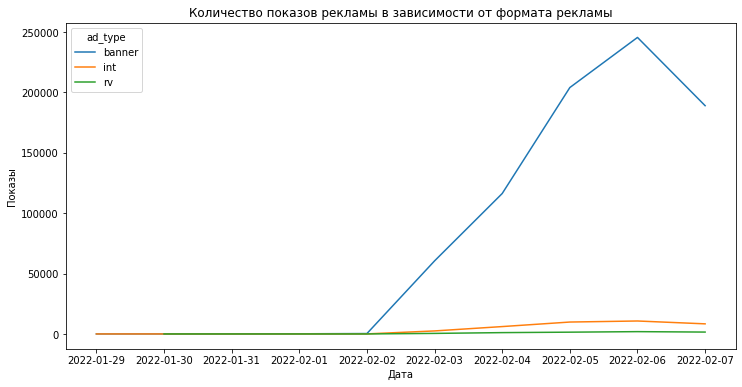

In [ ]:
t = df.groupby(["ad_type", "day"]).agg({"revenue" : lambda x: x.mean()*1000, "ad_type": "count" })
t.columns = ["revenue", "count"]
sns.lineplot(x="day", y="count", data=t[t['revenue']>0], hue="ad_type")
plt.xlabel("Дата")
plt.ylabel("Показы")
plt.title('Количество показов рекламы в зависимости от формата рекламы')
plt.show()

С 3 февраля заметно, что доля показов баннеров в общей сумме показов рекламы сильно начинает расти и превалировать.

Проверим, изменился ли с количеством рекламы баланс количества пользователей смотрящих разные форматы рекламы:

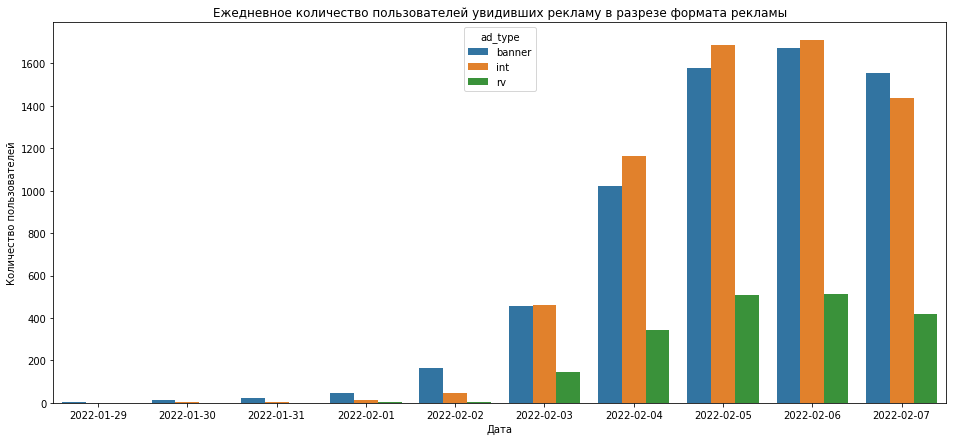

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
t = df.groupby(["day","ad_type"]).agg({"profile_id": lambda x: x.value_counts().count()})
t = t.reset_index()
sns.barplot(
    x="day",
    y="profile_id",
    data=t, hue = 'ad_type'
)
ax.set_ylabel
x_dates = t['day'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates)
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.title("Ежедневное количество пользователей увидивших рекламу в разрезе формата рекламы")
plt.show()

Несмотря на увеличение количества показов баннеров относительно других форматов, доля пользователей увидивших баннеры в сравнении с другими форматами не демонстрирует такой скачок.

Рекламная аудитория увеличилась почти равномерно для всех форматов рекламы.

#### eCPM

Ознакомимся с общими характеристиками столбца с выручкой:

In [ ]:
t = df['revenue']*1000
round(t.describe(),2)

count    860079.00
mean          2.78
std          15.13
min           0.00
25%           0.05
50%           0.49
75%           0.53
max         937.20
Name: revenue, dtype: float64

Заметим, что средний eCPM в 5 раз больше медианного.

Построим распределение средних eCPM-ов пользователей:

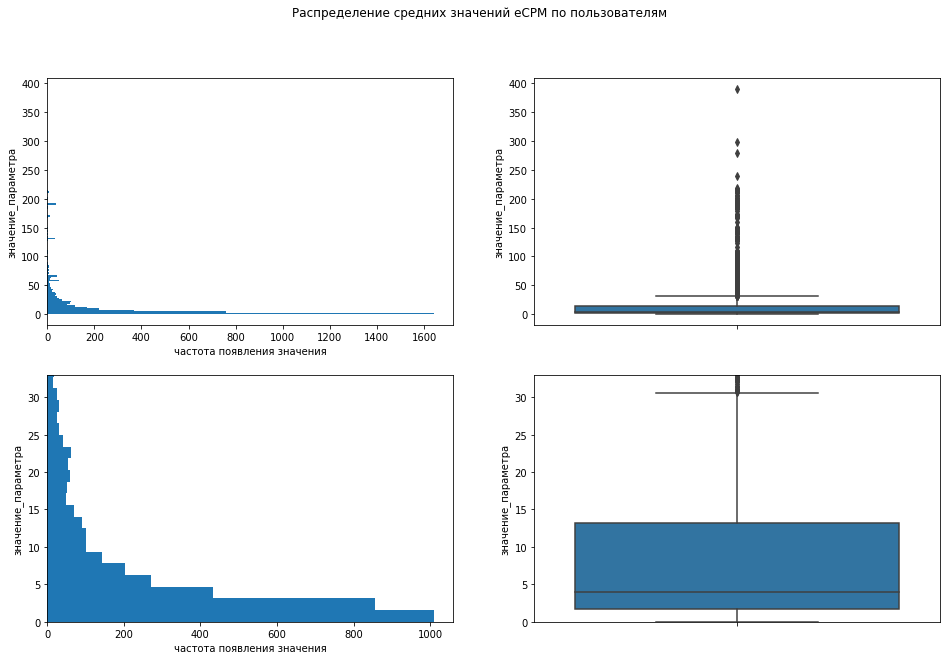

count    4227.000000
mean       15.786432
std        33.133510
min         0.036730
25%         1.677991
50%         3.913660
75%        13.258890
max       389.605621
Name: revenue, dtype: float64

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Распределение средних значений eCPM по пользователям")
y = df.groupby('profile_id')['revenue'].mean()*1000
ax[0, 0].set_xlabel("частота появления значения")
ax[0, 0].set_ylabel("значение_параметра")
ax[0, 1].set_ylabel("значение_параметра")
ax[0, 0].hist(y, orientation="horizontal", bins=150)
sns.boxplot(data=y, orient="v", ax=ax[0, 1])
ax[0, 1].set_xticklabels([])
ax[1, 0].set_xlabel("частота появления значения")
ax[1, 0].set_ylabel("значение_параметра")
ax[1, 0].hist(y, orientation="horizontal", bins=250)
ax[1, 0].set_ylim([0, 33])
ax[1, 1].set_ylabel("значение_параметра")
sns.boxplot(data=y, orient="v", ax=ax[1, 1])
ax[1, 1].set_ylim([0, 33])
ax[1, 1].set_xticklabels([])
plt.show()
y.describe()

Значения средней eCPM по пользователям имеет распределение с сильной положительной скошенностью. Поэтому среднее значение по выборке отличается от медианы.

Теперь проверим как менялся средняя дневная eCPM за это время:

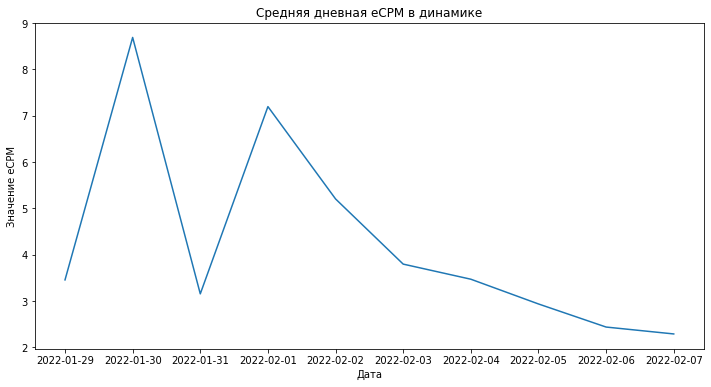

In [ ]:
t = df.groupby("day").agg({"revenue" : lambda x: x.mean()*1000})
sns.lineplot(x="day", y="revenue", data=t)
plt.xlabel("Дата")
plt.ylabel("Значение eCPM")
plt.title('Cредняя дневная eCPM в динамике')
plt.show()

До 3 февраля видны резкие перепады в eCPM, связанные, скорей всего с малым количеством показов рекламы. С 3 февраля можно заметить, что средняя дневная eCPM падает.

Проверим, как отличается eCPM в зависимости от формата рекламы:

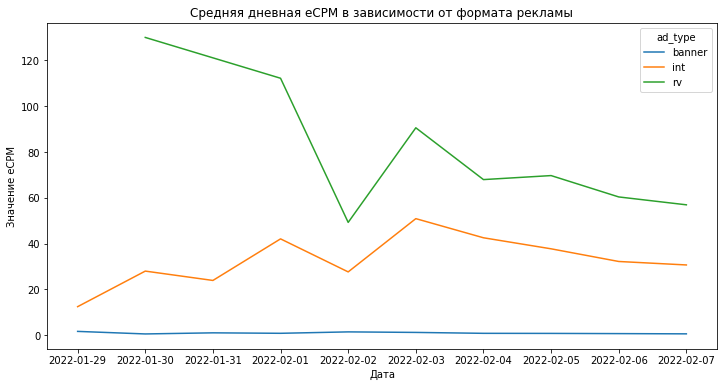

In [ ]:
t = df.groupby(["ad_type", "day"]).agg({"revenue" : lambda x: x.mean()*1000, "ad_type": "count" })
t.columns = ["revenue", "count"]
sns.lineplot(x="day", y="revenue", data=t, hue="ad_type")
plt.xlabel("Дата")
plt.ylabel("Значение eCPM")
plt.title('Cредняя дневная eCPM в зависимости от формата рекламы')
plt.show()

Отдельно посмотрим eCPM для формата рекламы "баннер":

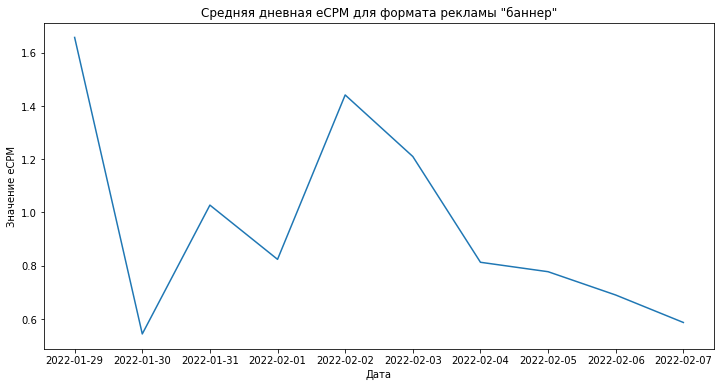

In [ ]:
t = df.groupby(["ad_type", "day"]).agg({"revenue" : lambda x: x.mean()*1000, "ad_type": "count" })
t.columns = ["revenue", "count"]
t = t.reset_index()
sns.lineplot(x="day", y="revenue", data=t[t['ad_type']=='banner'])
plt.xlabel("Дата")
plt.ylabel("Значение eCPM")
plt.title('Cредняя дневная eCPM для формата рекламы "баннер"')
plt.show()

У баннеров очень низкая eCPM, и соответственно, увеличив долю показов баннеров в общей сумме показов рекламы это, вероятно, стало основномй причиной падения средней дневной eCPM.

Проверим какой формат рекламы дает больше всего дохода:

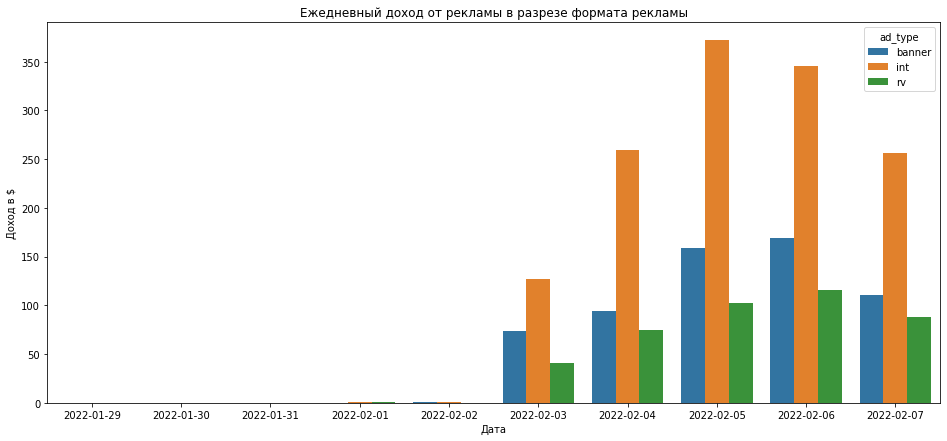

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
t = df.groupby(["day","ad_type"]).agg({"revenue": "sum"})
t = t.reset_index()
sns.barplot(
    x="day",
    y="revenue",
    data=t, hue = 'ad_type'
)
ax.set_ylabel
x_dates = t['day'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates)
plt.xlabel("Дата")
plt.ylabel("Доход в $")
plt.title("Ежедневный доход от рекламы в разрезе формата рекламы")
plt.show()

На первом месте идет полноэкранная реклама, далее баннер, и меньше всего приносит реклама "по желанию юзера".

Посмотрим среднюю дневную eCPM в зависимости от сети продвижения:

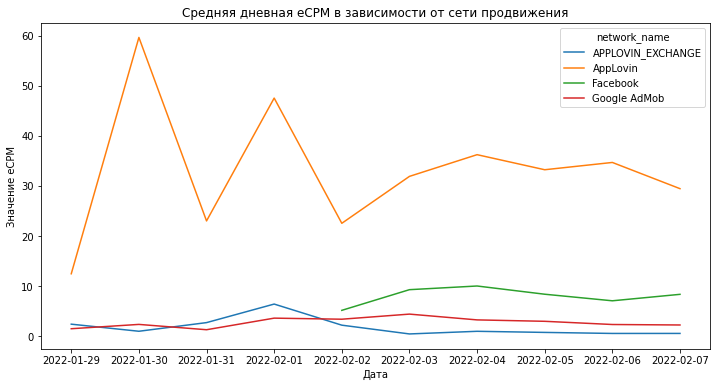

In [ ]:
t = df.groupby(["network_name", "day"]).agg({"revenue" : lambda x: x.mean()*1000, "network_name": "count" })
t.columns = ["revenue", "count"]
sns.lineplot(x="day", y="revenue", data=t, hue="network_name")
plt.xlabel("Дата")
plt.ylabel("Значение eCPM")
plt.title('Cредняя дневная eCPM в зависимости от сети продвижения')
plt.show()

Applovin выделяется своим высоким средним eCPM. Это, предположительно объясняется тем, что данная сеть [не используется для формата рекламы "баннер"](#app).


#### Отобразим средние eCPM-ы по городам

Ознакомимся для начала с характеристиками значений eCPM по городам:

In [ ]:
t = df.groupby('city')['revenue'].mean()*1000
t.describe()

count    921.000000
mean      10.278156
std       26.971288
min        0.040858
25%        1.596545
50%        3.042408
75%        6.561096
max      297.600000
Name: revenue, dtype: float64

Отличие среднего eCPM и медианного в 3 раза.

Выберем топ 20 городов по средней eCPM. Для этого найдем средние eCPM городов с количеством увидивших рекламу выше 20 человек и сравним со средней по всем городам. 

Создадим функцию определяющую критический уровень статистической значимости в зависимости от размера выборки:

In [ ]:
def define_alpha(a,b):
  if min(a,b)<100:
    return 0.05
  elif min(a,b)<1000:
    return 0.01
  else:
    return 0.001

Пропустим через цикл все города, сравнивая их средние eCPM со средней по всем городам и добавляя в список только прошедшие статистическую значимость:

In [ ]:
t = df.groupby('city').agg({"revenue" : 'mean', 'profile_id' : "count" }) 
t.columns = ["revenue", "count"]
t = t[t['count']>=20]  # отфильтруем города, где меньше 20 пользователям показывалась реклама
t = t.sort_values(by='revenue', ascending=False).reset_index() # сортируем города в порядке убывания eCPM
n=0
lst = t['city'].unique().tolist()
cities=[]
while len(cities)<=20:
  town1= lst[n]
  s1 = df.loc[df["city"] == town1, "revenue"]
  s2 = df.groupby('city')['revenue'].mean()
  results = scipy.stats.ttest_ind(s1, s2, equal_var=False) 
  alpha = define_alpha(len(s1),len(s2))
  if  results.pvalue/2<alpha:
    cities.append(town1)
  n+=1

Построим график по найденным городам:

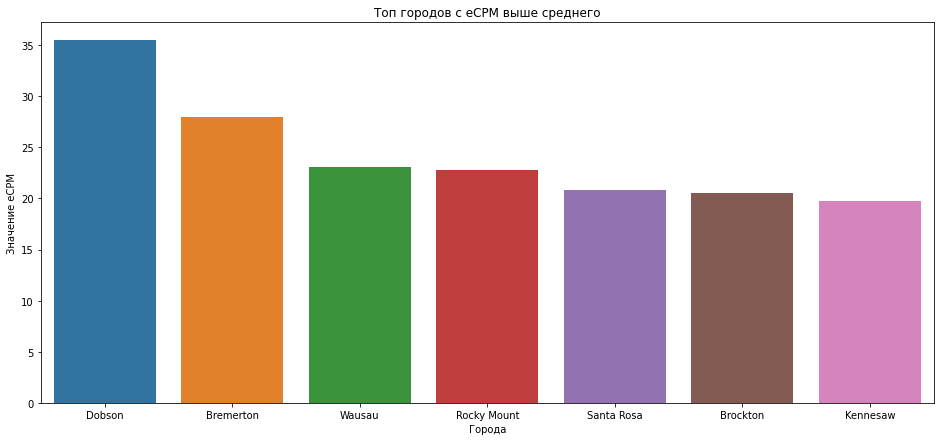

In [ ]:
t = df.groupby('city').agg({"revenue" : [lambda x: x.mean()*1000, "count"] })
t.columns = ["revenue", "count"]
t = t.reset_index()
t = t[t['city'].isin(cities)] # отфильтруем города 
t = t.sort_values(by='revenue', ascending=False)
fig, ax = plt.subplots(figsize=(16, 7))
sns.barplot(
    x= 'city',
    y = 'revenue',
    data=t[t['revenue']>df.groupby('city')['revenue'].mean().mean()*1000]
)
ax.set_ylabel("Значение eCPM")
ax.set_xlabel("Города")
plt.title("Топ городов c eCPM выше среднего")
# plt.xticks(rotation=45, ha='right')
plt.show()

Построим график для городов с высоким eCPM:

In [ ]:
df_geo = pd.DataFrame(columns={'city'}, data=[0])

geolocator = Nominatim(user_agent="my-application")
# geolocator = Nominatim()
n=0
for x in cities:
  try:
    location = geolocator.geocode(x)
    df_geo.loc[n,'city']= x
    df_geo.loc[n,'long']= location.longitude
    df_geo.loc[n,'lat']= location.latitude
    df_geo.loc[n,'revenue']= t[t['city']==x]['revenue'].to_list()[0]
    n+=1
  except:
    print(f'ошибка для {x}')

(-130.0, -60.0)

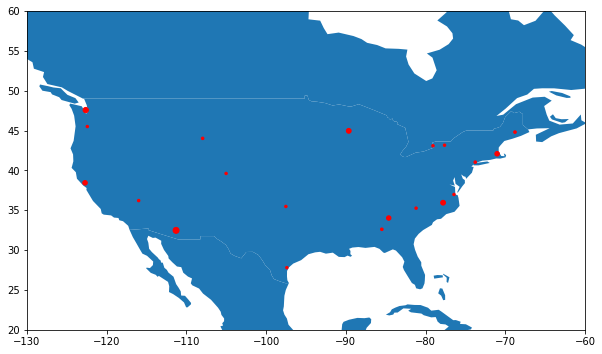

In [ ]:
geometry = [Point(xy) for xy in zip(df_geo['long'], df_geo['lat'])]
gdf = GeoDataFrame(df_geo, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize='revenue');
plt.ylim(20, 60)
plt.xlim(-130, -60)
# plt.show()

Если посмотреть 20 городов с высоким средним eCPM, то, в целом, говорить о какой-либо закономерности между eCPM и местоположением пользователя сложно.

#### Отобразим средние eCPM-ы по версиям ОС

Для начала отберем топ пять версий os по суммарным доходам от рекламы и посмотрим в динамике не менялась ли eCPM на них:

In [ ]:
lst = df.groupby("os_version")["revenue"].sum().sort_values(ascending=False).head(5).index.to_list()

Построим график:

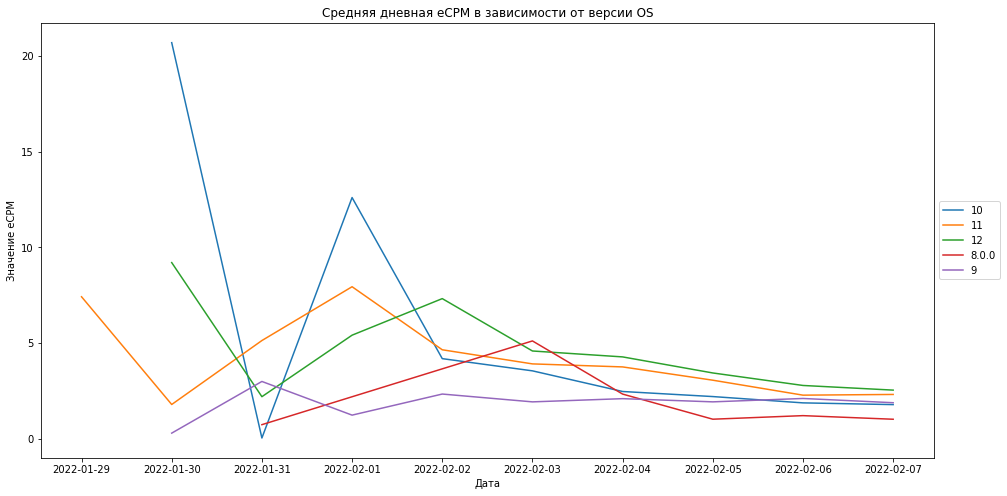

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
t = df[df['os_version'].isin(lst)].groupby(["os_version", "day"]).agg({"revenue" : lambda x: x.mean()*1000, "os_version": "count" })
t.columns = ["revenue", "count"]
sns.lineplot(x="day", y="revenue", data=t, hue="os_version")
plt.legend(loc="center", bbox_to_anchor=(1.04, 0.5)) 
plt.xlabel("Дата")
plt.ylabel("Значение eCPM")
plt.title('Cредняя дневная eCPM в зависимости от версии OS')
plt.show()

Сильных изменений в соотношении eCPM среди версий os после 3 ферваля не выявлено. Снижение заметно для всех топ версий.

Посчитаем средние eCPM для версий os без учета динамики:

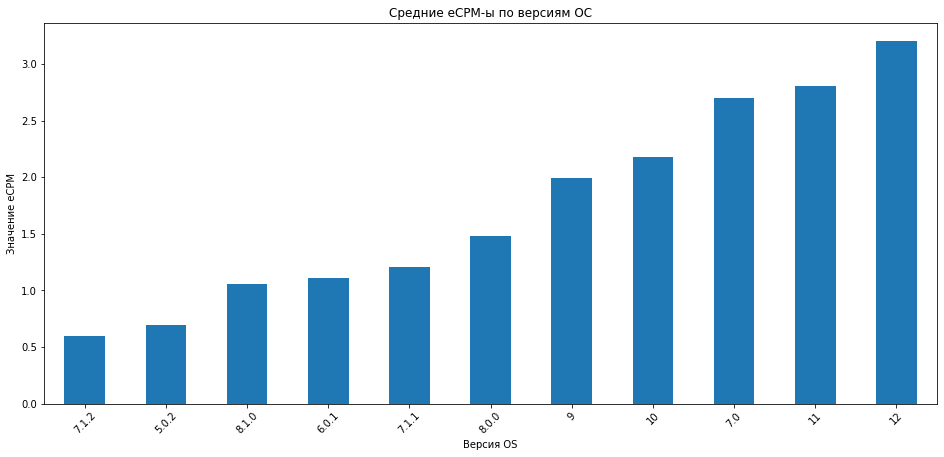

In [ ]:
t = df.groupby('os_version')['revenue'].mean()*1000
t = t.sort_values()
fig, ax = plt.subplots(figsize=(16, 7))
t.plot(kind='bar')
plt.xticks(rotation=45)
ax.set_ylabel("Значение eCPM")
ax.set_xlabel("Версия OS")
plt.title("Средние eCPM-ы по версиям ОС")
plt.show()

Сразу проверим наши результаты на значимость.

Посмотрим количество данных по каждой из версий os:

In [ ]:
df['os_version'].value_counts()

12       407587
11       209071
10       150871
9         66662
8.1.0      9249
8.0.0      8016
7.0        4057
7.1.2      1811
7.1.1      1342
5.0.2       709
6.0.1       704
Name: os_version, dtype: int64

Пропустим через цикл все версии os, сравнивая их средние и выводя pvalue если он выше критического уровня статистической значимости:

In [ ]:
for os1 in df['os_version'].unique().tolist():
  for os2 in df['os_version'].unique().tolist():
    if os1 != os2 :
      s1 = df.loc[df["os_version"] == os1, "revenue"]
      s2 = df.loc[df["os_version"] == os2, "revenue"]
      results = scipy.stats.ttest_ind(s1, s2, equal_var=False) 
      alpha = define_alpha(len(s1),len(s2))
      if  results.pvalue>alpha:
        print('Для', str(os1), 'и', str(os2), 'pvalue', round(results.pvalue,3))

Для 11 и 7.0 pvalue 0.68
Для 10 и 7.0 pvalue 0.048
Для 12 и 7.0 pvalue 0.057
Для 9 и 7.0 pvalue 0.008
Для 8.0.0 и 6.0.1 pvalue 0.028
Для 8.0.0 и 7.1.1 pvalue 0.066
Для 6.0.1 и 8.0.0 pvalue 0.028
Для 6.0.1 и 8.1.0 pvalue 0.726
Для 6.0.1 и 7.1.1 pvalue 0.602
Для 6.0.1 и 5.0.2 pvalue 0.021
Для 8.1.0 и 6.0.1 pvalue 0.726
Для 8.1.0 и 7.1.1 pvalue 0.254
Для 7.0 и 11 pvalue 0.68
Для 7.0 и 10 pvalue 0.048
Для 7.0 и 12 pvalue 0.057
Для 7.0 и 9 pvalue 0.008
Для 7.1.2 и 5.0.2 pvalue 0.482
Для 7.1.1 и 8.0.0 pvalue 0.066
Для 7.1.1 и 6.0.1 pvalue 0.602
Для 7.1.1 и 8.1.0 pvalue 0.254
Для 5.0.2 и 6.0.1 pvalue 0.021
Для 5.0.2 и 7.1.2 pvalue 0.482


 После проверки значимости, можно говорить, что соотношение полученных средних eCPM сохраняется для версий os выше 9 и включая её.

Особое внимание стоит обратить на версию os 7, которая по своим показателям может быть в пятерке лучших по средней eCPM, но из-за малой выборки мы не может дать четкий вывод о ее нахождении в лидерах. 

Заключаем, что версия os влияет на eCPM. Причем, по большей вероятности, чем выше версия os - тем выше eCPM. 

#### Отобразим суммарные доходы по городам

Прежде чем определять суммарные доходы по городам, нужно понять, какой процент доходов относиться к рекламе с отсутствием информации о городе:

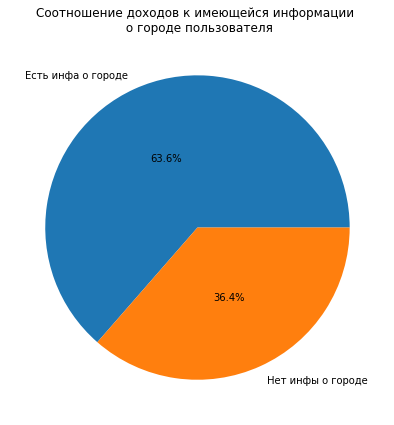

In [ ]:
t = df.copy()
t = t.groupby(t["city"] == "unknown")['revenue'].sum()
t = t.rename(index={True:'Нет инфы о городе', False:'Есть инфа о городе'})

fig, ax = plt.subplots(figsize=(16, 7))

labels = t.keys()
plt.pie(x=t, autopct="%.1f%%",  labels=labels, pctdistance=0.5)

plt.title("Соотношение доходов к имеющейся информации \n о городе пользователя")
plt.show()

Больше трети доходов не имеют информации о городе.

Посмотрим топ 10 городов по доходам:

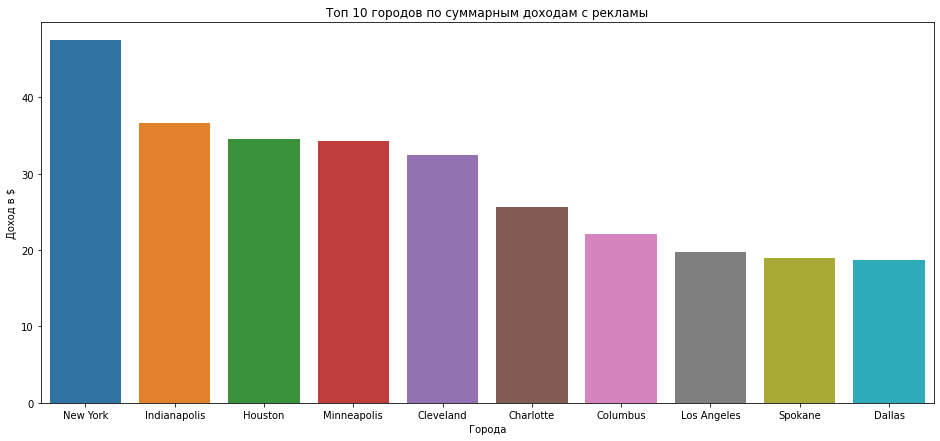

In [ ]:
t = df[df["city"]!='unknown'].groupby('city')['revenue'].sum()
t = t.sort_values(ascending=False).head(10).reset_index()
fig, ax = plt.subplots(figsize=(16, 7))
ax.set_ylabel("Количество лет существования платформы по имеющимся данным")
sns.barplot(
    x= t['city'],
    y = t['revenue'],
    data=t
)
ax.set_ylabel("Доход в $")
ax.set_xlabel("Города")
plt.title("Топ 10 городов по суммарным доходам с рекламы")
plt.show()

Проверим eCPM этих городов:

In [ ]:
lst = t['city'].to_list()
t = t.set_index('city')
for x in lst:
  t.loc[x,'eCPM'] = df[df['city']==x].groupby('city')['revenue'].mean()[0]*1000
t

,revenue,eCPM
city,,
New York,47.454397,2.698726
Indianapolis,36.679515,5.147280
Houston,34.551763,3.408480
Minneapolis,34.235291,2.637542
Cleveland,32.475495,5.037303
Charlotte,25.620972,2.627792
Columbus,22.158861,3.551669
Los Angeles,19.740347,3.099929
Spokane,18.923951,3.171435


eCPM найденных топ 10 городов ниже средней eCPM по городам в целом. Но, в основном, выше медианной eCPM по городам. Что не так плохо.

Отобразим на карте топ 20 городов по общей доходности:

In [ ]:
t = df[df["city"]!='unknown'].groupby('city')['revenue'].sum()
cities = t.sort_values(ascending=False).head(20)
cities = cities.reset_index()['city'].tolist()
t = t.reset_index()
df_geo = pd.DataFrame(columns={'city'}, data=[0])

geolocator = Nominatim(user_agent="my-application")
n=0
for x in cities:
  try:
    location = geolocator.geocode(x)
    df_geo.loc[n,'city']= x
    df_geo.loc[n,'long']= location.longitude
    df_geo.loc[n,'lat']= location.latitude
    df_geo.loc[n,'revenue']= t[t['city']==x]['revenue'].to_list()[0]
    n+=1
  except:
    print(f'ошибка для {x}')

(-130.0, -65.0)

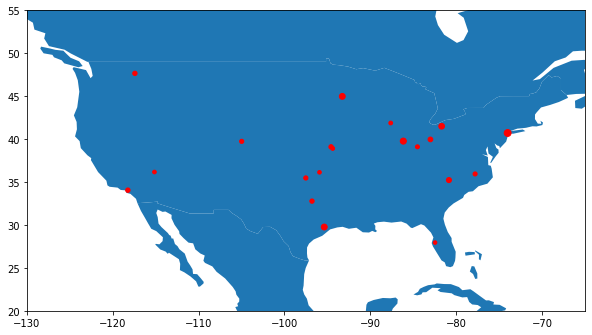

In [ ]:
geometry = [Point(xy) for xy in zip(df_geo['long'], df_geo['lat'])]
gdf = GeoDataFrame(df_geo, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize='revenue');
plt.ylim(20, 55)
plt.xlim(-130, -65)

В целом, заметно, что города с самыми высокими доходами от рекламы это не топ городов с высоким eCPM. Есть куда двигаться.

#### Отобразим суммарные доходы по версиям OS

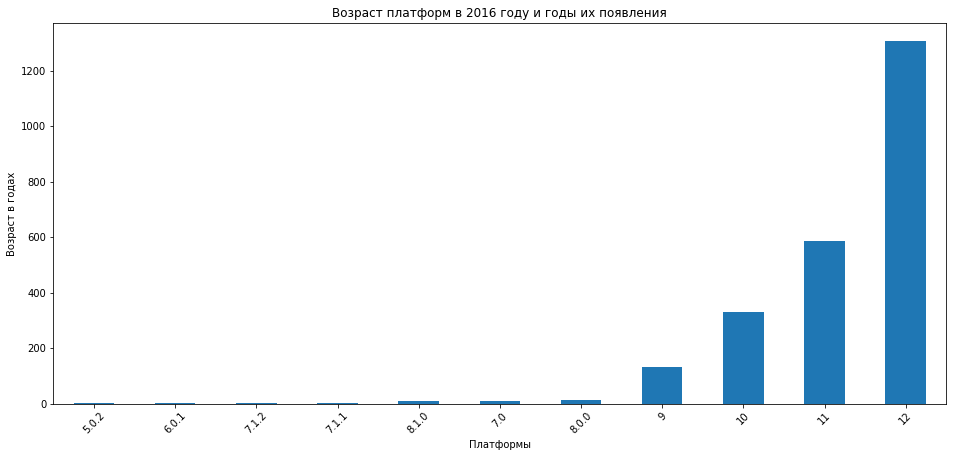

In [ ]:
t = df.groupby('os_version')['revenue'].sum()
t = t.sort_values()
fig, ax = plt.subplots(figsize=(16, 7))
ax.set_ylabel("Количество лет существования платформы по имеющимся данным")
t.plot(kind='bar')
ax.set_ylabel("Возраст в годах")
ax.set_xlabel("Платформы")
plt.xticks(rotation=45)
plt.title("Возраст платформ в 2016 году и годы их появления")
plt.show()

Очень хорошо заметно, что чем новее os - тем больше выручки приносит реклама на таких устройствах.

# Вывод

Мы провели исследовательский анализ данных рекламы дипазоном дат с 29 января по 7 февраля 2022 года.

Из анализа выяснилось, что начиная с 3 февраля выросли показы рекламы, количество показов рекламы на пользователя, выросла рекламная аудитория.

Почему такой рост произошел можно погадать. Вероятно, постепенно интегрировали рекламу и сначала просто тестировали, а потом раскатали на всех. Либо в самой игре было мало пользователей, а потом сделали заливку траффика.

Но судя по росту просмотров на 1 человека более вероятен первый вариант. Не  исключая при этом внедрения и второго. 




При этом, средняя eCPM начала снижаться, особенно активно после 3 февраля, на фоне резко увеличившихся показов рекламы формата "баннер". Вероятно, эти два процесса взаимосвязаны.


Наиболее высокий eCPM идет от рекламы-видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы, но суммарный дневной доход относительно других форматов небольшой. Вероятно, можно подумать над увеличением количества такого формата рекламы.


С помощью анализа, было установлено, что чем свежее версия os, на котором запускается реклама, тем выше eCPM и общая выручка с таких устройств. Можно сделать предположение, что чем новее os, тем новее и дороже устройство, тем более платежеспособной считается аудитория, и дороже показать им рекламу.


Города с самыми высокими доходами от рекламы это не топ городов с высоким eCPM. А значит, можно акцентировать внимание на последних и устранить эту неэффективность. 